## Import libraries

In [1]:
import warnings

warnings.filterwarnings("ignore")
from ipywidgets import FloatProgress

import os
import time
import random
import pandas as pd
import pickle
import numpy as np
from tqdm.auto import tqdm
from datetime import datetime
from itertools import product
import torch
from typing import Tuple
from torch import nn
import matplotlib.pyplot as plt
from darts.utils.callbacks import TFMProgressBar
from darts import TimeSeries
from darts.metrics import *
from darts.utils.losses import *
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode
from darts.utils.missing_values import fill_missing_values
from darts.models import *
from darts.datasets import *
from darts.datasets import TrafficDataset, AirPassengersDataset, AustralianTourismDataset
from ucimlrepo import fetch_ucirepo 
from darts.utils.timeseries_generation import datetime_attribute_timeseries, holidays_timeseries
import tqdm

In [2]:
HORIZON = 48

In [3]:
def generate_torch_kwargs():
    # run torch models on CPU, and disable progress bars for all model stages except training.
    return {
        "pl_trainer_kwargs": {
            "accelerator": "mps",
            "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        }
    }

In [4]:
def eval_forecasts(
    pred_series: List[TimeSeries], test_series: List[TimeSeries]
) -> List[float]:

    print("computing MAEs...")
    maes = mae(test_series, pred_series)
    plt.figure()
    plt.hist(maes, bins=50)
    plt.ylabel("Count")
    plt.xlabel("MAE")
    plt.title("Median MAE: %.3f" % np.median(maes))
    plt.show()
    plt.close()
    return maes

## Import Data
- We try multiple datasets to see which provides us with the best outcome

## Electricity Model

In [5]:
elec = ElectricityDataset(multivariate=False).load()[5].astype(np.float32)
elec = fill_missing_values(elec, 'auto')
elec = elec.drop_columns(elec.pd_dataframe().isna().all()[elec.pd_dataframe().isna().all()].index.values)
columns_to_drop = [col for col in elec.pd_dataframe().columns if col.startswith('generation')]
elec = elec.drop_columns(columns_to_drop)
_ , elec = elec.resample('1H').split_before(1)

  0%|          | 0/370 [00:00<?, ?it/s]

In [6]:
elec_train, elec_test = elec[:-HORIZON], elec[-HORIZON:]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | criterion        | MSELoss          | 0      | train
1 | train_criterion  | MSELoss          | 0      | train
2 | val_criterion    | MSELoss          | 0      | train
3 | train_metrics    | MetricCollection | 0      | train
4 | val_metrics      | MetricCollection | 0      | train
5 | encoders         | Sequential       | 22.9 K | train
6 | decoders         | Sequential       | 66.0 K | train
7 | temporal_decoder | _ResidualBlock   | 594    | train
8 | lookback_skip    | Linear           | 300    | train
--------------------------------------------------------------
89.9 K    Trainable params
0         Non-trainable params
89.9 K    Total params
0.359     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


computing MAEs...


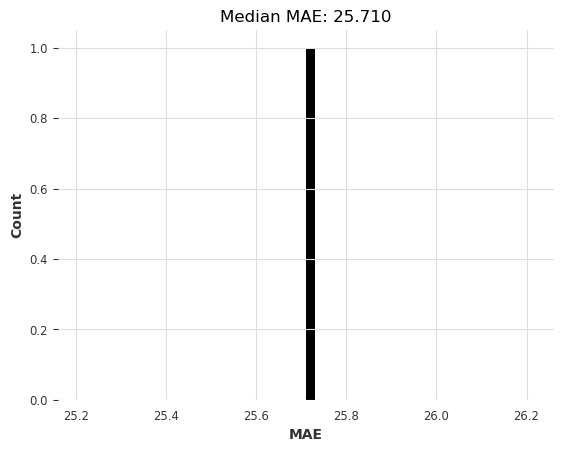

In [7]:
# reproducibility
np.random.seed(42)
torch.manual_seed(42)

start_time = time.time()

model_elec = TiDEModel(
    input_chunk_length=96,
    output_chunk_length=24,
    **generate_torch_kwargs()
)
MAX_SAMPLES_PER_TS = (
    96  # <-- new parameter, limiting the number of training samples per series
)

model_elec.fit(elec_train, epochs=30)

# get predictions
tide_preds = model_elec.predict(series=elec_train, n=HORIZON)
tide_elapsed_time = time.time() - start_time

tide_maes = eval_forecasts(tide_preds, elec_test)

In [8]:
mse(elec_test, tide_preds)

1126.9009

MAE = 25.71


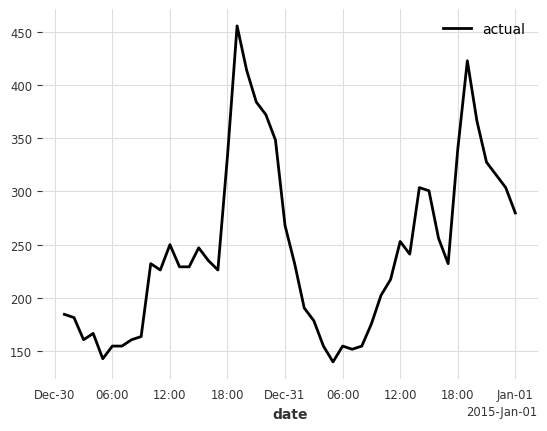

In [9]:
elec_test.plot(label="actual")
plt.legend()
print("MAE = {:.2f}".format(mae(elec_test, tide_preds)))

<Axes: xlabel='date'>

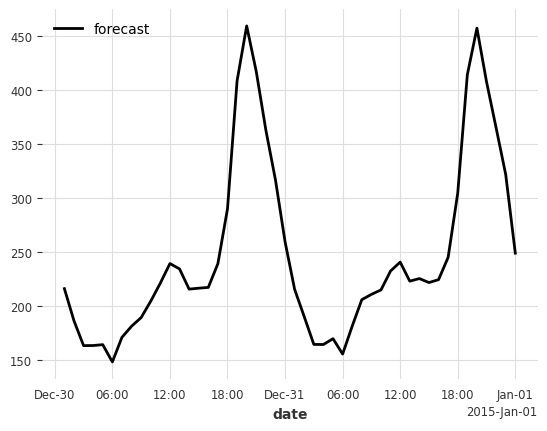

In [10]:
tide_preds.plot(label="forecast")

MAE = 25.71


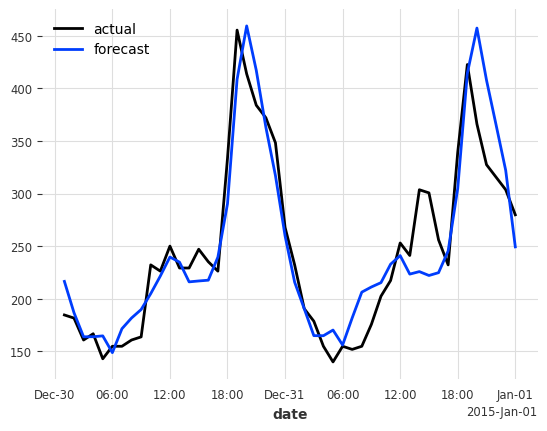

In [11]:
elec_test.plot(label="actual")
tide_preds.plot(label="forecast")
plt.legend()
print("MAE = {:.2f}".format(mae(elec_test, tide_preds)))

# Load Room Est

In [22]:
room_occupancy_estimation = fetch_ucirepo(id=864) 
room_df = room_occupancy_estimation['data']['features']
room_df = pd.concat([room_df, room_occupancy_estimation['data']['targets']], axis = 1)

In [23]:
room_df.fillna(-1, inplace=True)
room_df['Datetime'] = pd.to_datetime(room_df['Date'] + ' ' + room_df['Time'])
room_df = room_df.set_index('Datetime').resample('30s').ffill()
room_df.dropna(inplace=True)
final_df = room_df.drop(columns=['Date', 'Time'])
final_df.reset_index(inplace=True)

In [24]:
room_ts = TimeSeries.from_dataframe(df=final_df, time_col='Datetime', freq='30s', value_cols='Room_Occupancy_Count').astype(np.float32)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<Axes: xlabel='Datetime'>

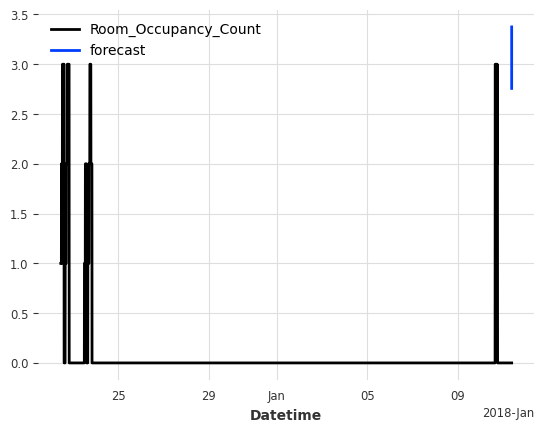

In [30]:
room_ts.plot('actual')
model_elec.predict(series=room_ts, n=2).plot(label="forecast")

In [31]:
from src.forecasting_engine import get_data, write_forecast

ModuleNotFoundError: No module named 'dotenv'

In [ ]:
end = datetime.now()
start = (end - pd.timedelta(hours=24)).strftime('%Y-%m-%dT%H:%M:%S')
end = end.strftime('%Y-%m-%dT%H:%M:%S')

data_raw = get_data(start = start, end = end) ## only use the last 24 hours as input
n_future = 24

## Get forecast dates and times
end_time = datetime.now() + pd.timedelta(hours = int(n_future/4))
future_times = []
current_time = datetime.now()
while current_time <= end_time:
    future_times.append(current_time.strftime('%Y-%m-%dT%H:%M:%S'))
    current_time += pd.timedelta(minutes=15)